In [42]:
import torch
import mlflow
from flatbuffers.packer import float32

from config import RAW_DATA_DIR

In [44]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from IPython.display import HTML

In [45]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Prep Dataset ###
tensor_transforms = transforms.Compose(
    [
        transforms.Resize((64, 28)),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.MNIST(root=RAW_DATA_DIR / 'mnist', train=True, transform=tensor_transforms,
                                           download=True)
val_dataset = torchvision.datasets.MNIST(root=RAW_DATA_DIR / 'mnist', train=False, transform=tensor_transforms,
                                         download=True)
batch_size = 1024
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=6)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=True, num_workers=6)

### Set Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
import math
class VAE(nn.Module):
    def __init__(self, latent_dim=2, input_size=28 * 28):
        super().__init__()
        self.input_size: int = input_size
        self.latent_dim: int = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.fn_mu = nn.Linear(32, self.latent_dim)
        self.fn_logvar = nn.Linear(32, self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )
    def forward_dec(self, x):
        return self.decoder(x)

    def forward_enc(self, x):

        x = self.encoder(x)
        mu = self.fn_mu(x)
        logvar = self.fn_logvar(x)

        sigma = torch.exp(0.5 * logvar)
        noise = torch.randn_like(logvar, device=logvar.device)

        z = mu + sigma * noise
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.forward_enc(x)

        return z, self.decoder(z), mu, logvar



In [66]:
def VAELoss(x, x_hat, mean, log_var, kl_weight=1, reconstruction_weight=1):
    pixel_mse = ((x - x_hat)**2)

    #reconstruction_loss = pixel_mse.sum(axis=-1).mean()
    reconstruction_loss = pixel_mse.mean()


    kl = (1 + log_var - mean**2 - torch.exp(log_var))

    kl_per_image = -0.5 * torch.sum(kl, dim=-1)


    kl_loss = torch.mean(kl_per_image)
    #print(reconstruction_loss, kl_loss)

    return reconstruction_loss, kl_loss, reconstruction_loss * reconstruction_weight + kl_weight * kl_loss

x = torch.randn(4, 128)
x_hat = torch.randn(4, 128)

mean = torch.randn(4, 2)
log_var = torch.randn(4, 2)

VAELoss(x, x_hat, mean, log_var)


(tensor(1.9271), tensor(1.3606), tensor(3.2878))

# Trainning

In [67]:
val_dataset.data.shape[1]

28

In [68]:
from loguru import logger
mlflow.set_experiment("unsupervized_ml_sandbox")

logger.info(f"model_name : VAE")



2025-07-18 11:09:04.501 | INFO     | __main__:<module>:4 - model_name : VAE


In [71]:
with mlflow.start_run(run_name="vae"):
    kl_weight = 0.1
    input_size = val_dataset.data.shape[1]**2
    epochs = 100
    model = VAE(latent_dim=2, input_size=input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    val_step = 5


    mlflow.log_param("kl_weight", kl_weight)
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("model", model)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("val_step", val_step)


    torch.set_float32_matmul_precision('high')

    train_loss = []

    encoded_data_per_eval = []
    train_losses =[]
    r_losses = []
    kl_losses = []
    val_losses =[]


    model.train()

    train = True

    for epoch in tqdm(range(epochs)):
        train_loss_epoch = []
        r_loss_epoch = []
        kl_loss_epoch = []

        for imgs, _ in train_dl:
            imgs = imgs.to(device)
            imgs = imgs.flatten(1)

            encoded, decoded, mu, logvar = model(imgs)

            r_loss, kl_loss, loss = VAELoss(imgs, decoded, mu, logvar, kl_weight=kl_weight)

            train_loss_epoch.append(loss.item())
            r_loss_epoch.append(r_loss.item())
            kl_loss_epoch.append(kl_loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(np.mean(train_loss_epoch))
        kl_losses.append(np.mean(kl_loss_epoch))
        r_losses.append(np.mean(r_loss_epoch))



        if epoch % val_step == 0:
            model.eval()
            val_loss_epoch = []

            with torch.no_grad():
                for img, _ in val_dl:
                    img = img.to(device)
                    img = img.flatten(1)
                    encoded, decoded, mu, logvar = model(img)
                    _, _, loss = VAELoss(img, decoded, mu, logvar, kl_weight=kl_weight)
                    val_loss_epoch.append(loss.item())

            avg_val_loss = np.mean(val_loss_epoch)
            avg_train_loss = np.mean(train_losses)
            avg_kl_loss = np.mean(kl_losses)
            avg_r_loss = np.mean(r_losses)

            print(f"Epoch {epoch} — train_loss: {avg_train_loss:.6f} — val_loss: {avg_val_loss:.6f}")
            mlflow.log_metric("val_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("train_loss", avg_val_loss, step=epoch)
            mlflow.log_metric("kl_loss", avg_kl_loss, step=epoch)
            mlflow.log_metric("r_loss", avg_r_loss, step=epoch)
                    # on sauvegarde les moyennes

            train_losses = []
            kl_losses = []
            r_losses = []


            model.train()





  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 — train_loss: 0.131078 — val_loss: 0.073510
Epoch 5 — train_loss: 0.064691 — val_loss: 0.057511
Epoch 10 — train_loss: 0.054552 — val_loss: 0.052385
Epoch 15 — train_loss: 0.050108 — val_loss: 0.048641
Epoch 20 — train_loss: 0.047241 — val_loss: 0.046617
Epoch 25 — train_loss: 0.045554 — val_loss: 0.045378
Epoch 30 — train_loss: 0.044448 — val_loss: 0.044522
Epoch 35 — train_loss: 0.043709 — val_loss: 0.044061
Epoch 40 — train_loss: 0.043110 — val_loss: 0.043646
Epoch 45 — train_loss: 0.042607 — val_loss: 0.043125
Epoch 50 — train_loss: 0.042188 — val_loss: 0.042941
Epoch 55 — train_loss: 0.041823 — val_loss: 0.042620
Epoch 60 — train_loss: 0.041486 — val_loss: 0.042261
Epoch 65 — train_loss: 0.041193 — val_loss: 0.042059
Epoch 70 — train_loss: 0.040906 — val_loss: 0.041826
Epoch 75 — train_loss: 0.040651 — val_loss: 0.041592
Epoch 80 — train_loss: 0.040399 — val_loss: 0.041432
Epoch 85 — train_loss: 0.040202 — val_loss: 0.041260
Epoch 90 — train_loss: 0.039968 — val_loss: 0.04

In [51]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (fn_mu): Linear(in_features=32, out_features=2, bias=True)
  (fn_logvar): Linear(in_features=32, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [72]:
encoded_data_per_eval = []
decoded_data_per_eval = []
encoded_labels_per_eval = []
raw_data_per_eval = []

model.eval()

for imgs, label in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    encoded, decoded, _, _ = model(imgs)
    encoded_data_per_eval.append(encoded)
    encoded_labels_per_eval.append(label)
    decoded_data_per_eval.append(decoded)
    raw_data_per_eval.append(imgs)


encoded_data = torch.cat(encoded_data_per_eval, dim=0)
encoded_labels = torch.cat(encoded_labels_per_eval, dim=0)
decoded_data = torch.cat(decoded_data_per_eval, dim=0)
raw_data = torch.cat(raw_data_per_eval, dim=0)




In [73]:
encoded_data.shape

torch.Size([60000, 2])

## Représentation dans l'espace latent

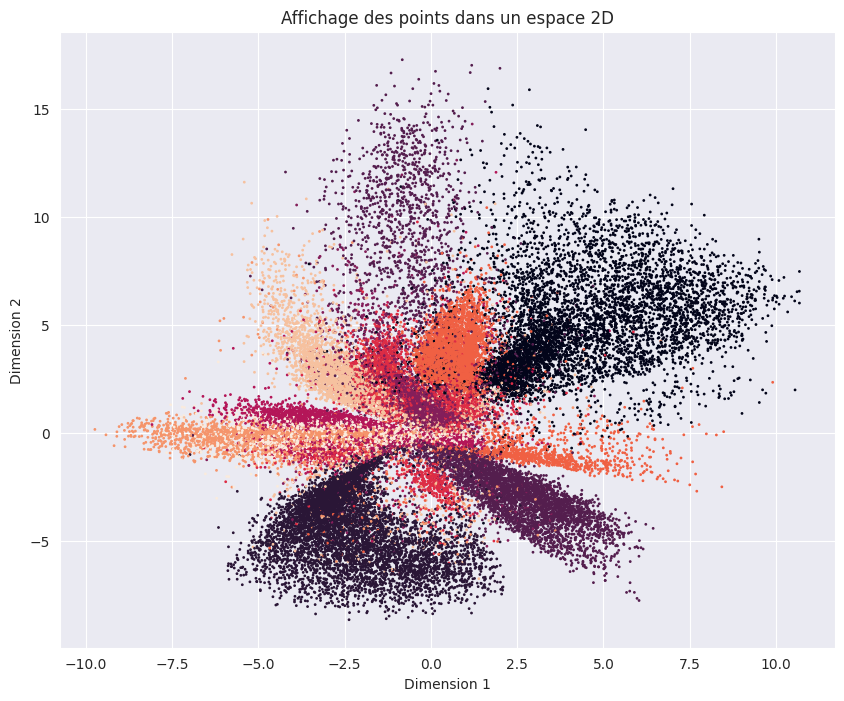

In [74]:
np_encoded_data = encoded_data.detach().cpu().numpy()
np_encoded_labels = encoded_labels.detach().cpu().numpy()
plt.figure(figsize=(10, 8))
plt.scatter(np_encoded_data[:, 0], np_encoded_data[:, 1], s=1, c=np_encoded_labels) # s est la taille des points
plt.title('Affichage des points dans un espace 2D')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# encodeur -> decodeur

In [75]:
print(raw_data.shape, decoded_data.shape)

torch.Size([60000, 784]) torch.Size([60000, 784])


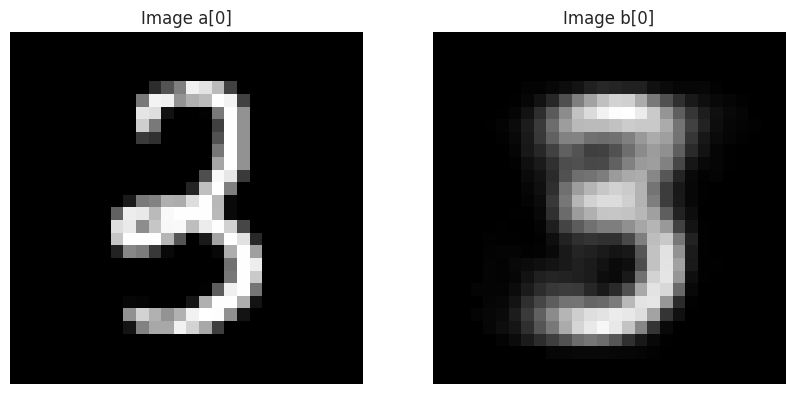

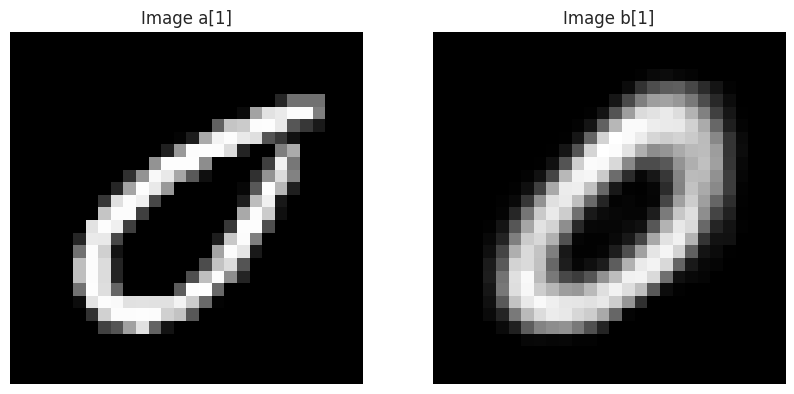

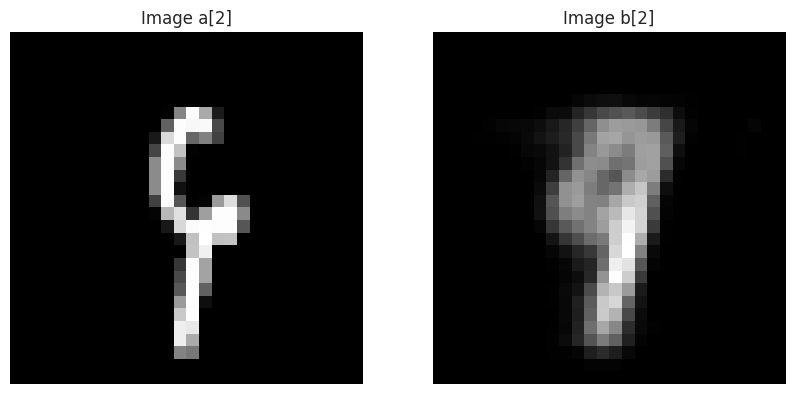

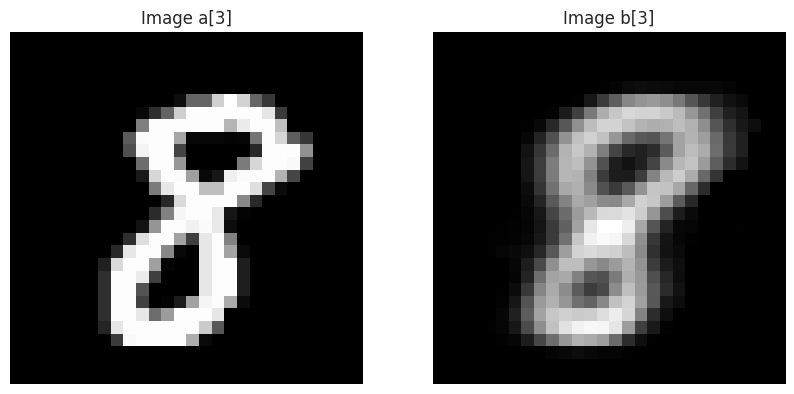

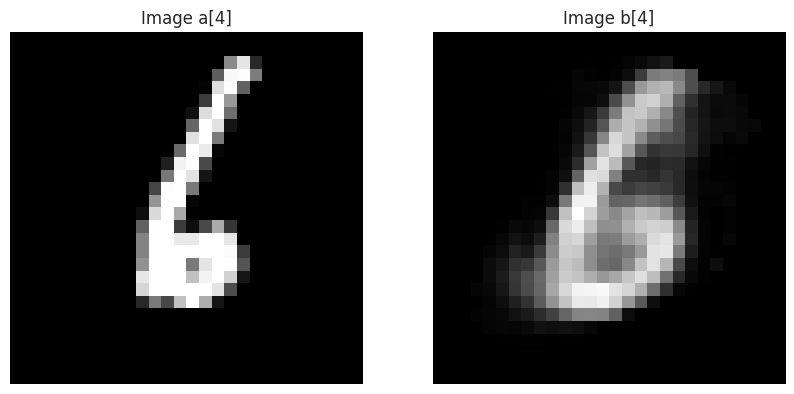

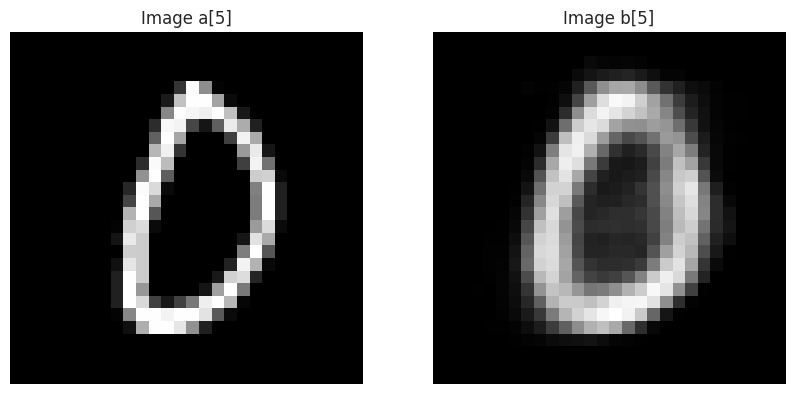

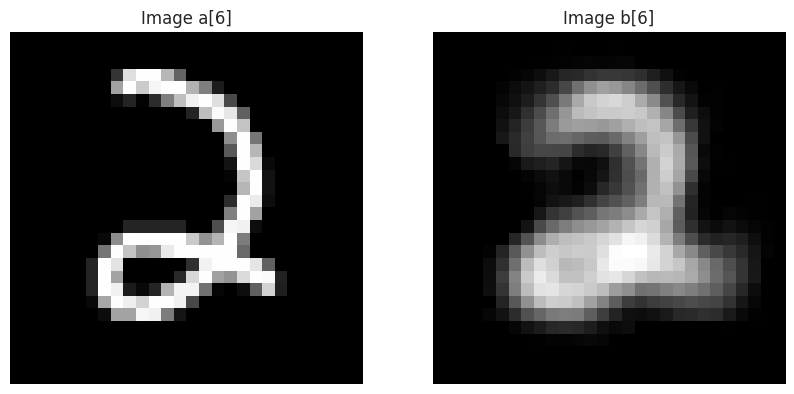

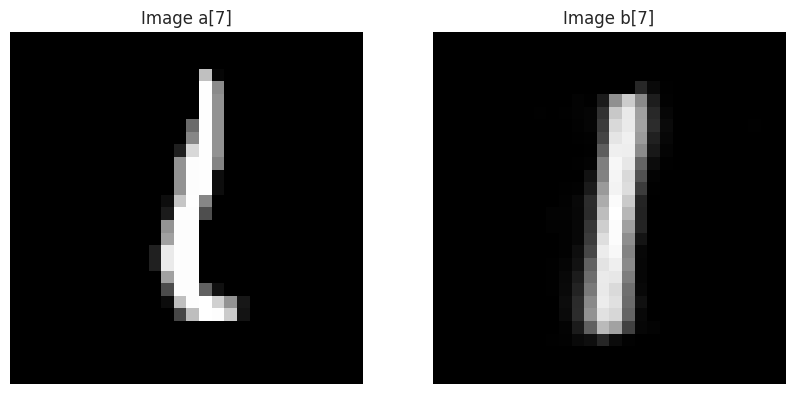

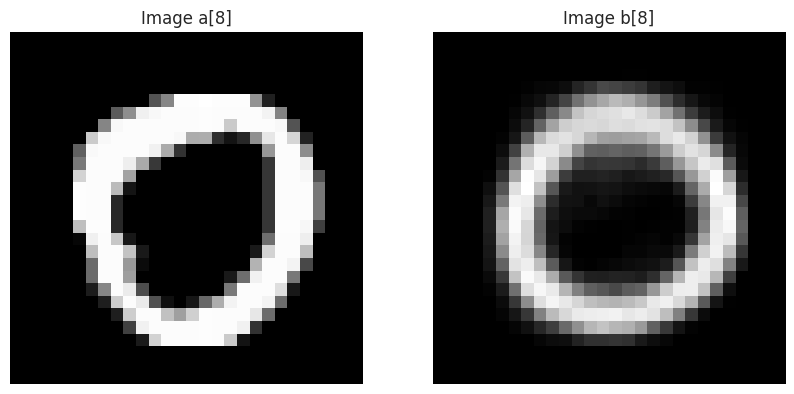

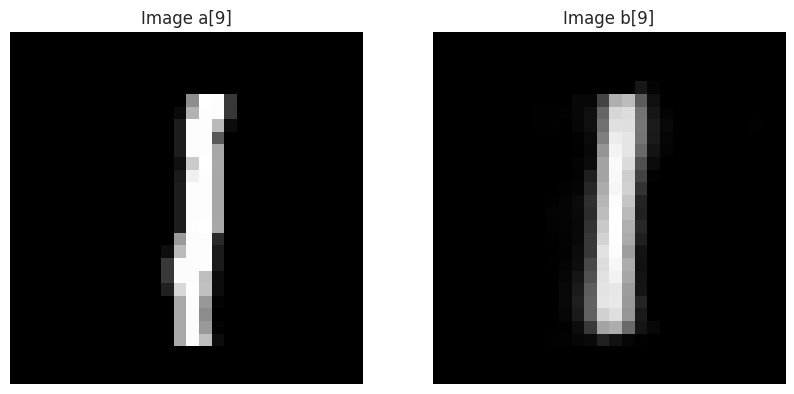

In [76]:
np_decoded_data = decoded_data.detach().cpu().numpy()
np_raw_data = raw_data.detach().cpu().numpy()
for i in range(10):
    # Transformation des vecteurs en images 28x28
    image_a = np_raw_data[i].reshape(28, 28)
    image_b = np_decoded_data[i].reshape(28, 28)

    # Création d'une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage des images
    axes[0].imshow(image_a, cmap='gray')
    axes[0].set_title(f'Image a[{i}]')
    axes[0].axis('off')

    axes[1].imshow(image_b, cmap='gray')
    axes[1].set_title(f'Image b[{i}]')
    axes[1].axis('off')

    plt.show()

In [77]:
points = np_encoded_data
# Définir les limites du quadrillage
x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()

In [78]:
grid_size = 20
x_coords = np.linspace(x_min, x_max, grid_size)
y_coords = np.linspace(y_min, y_max, grid_size)


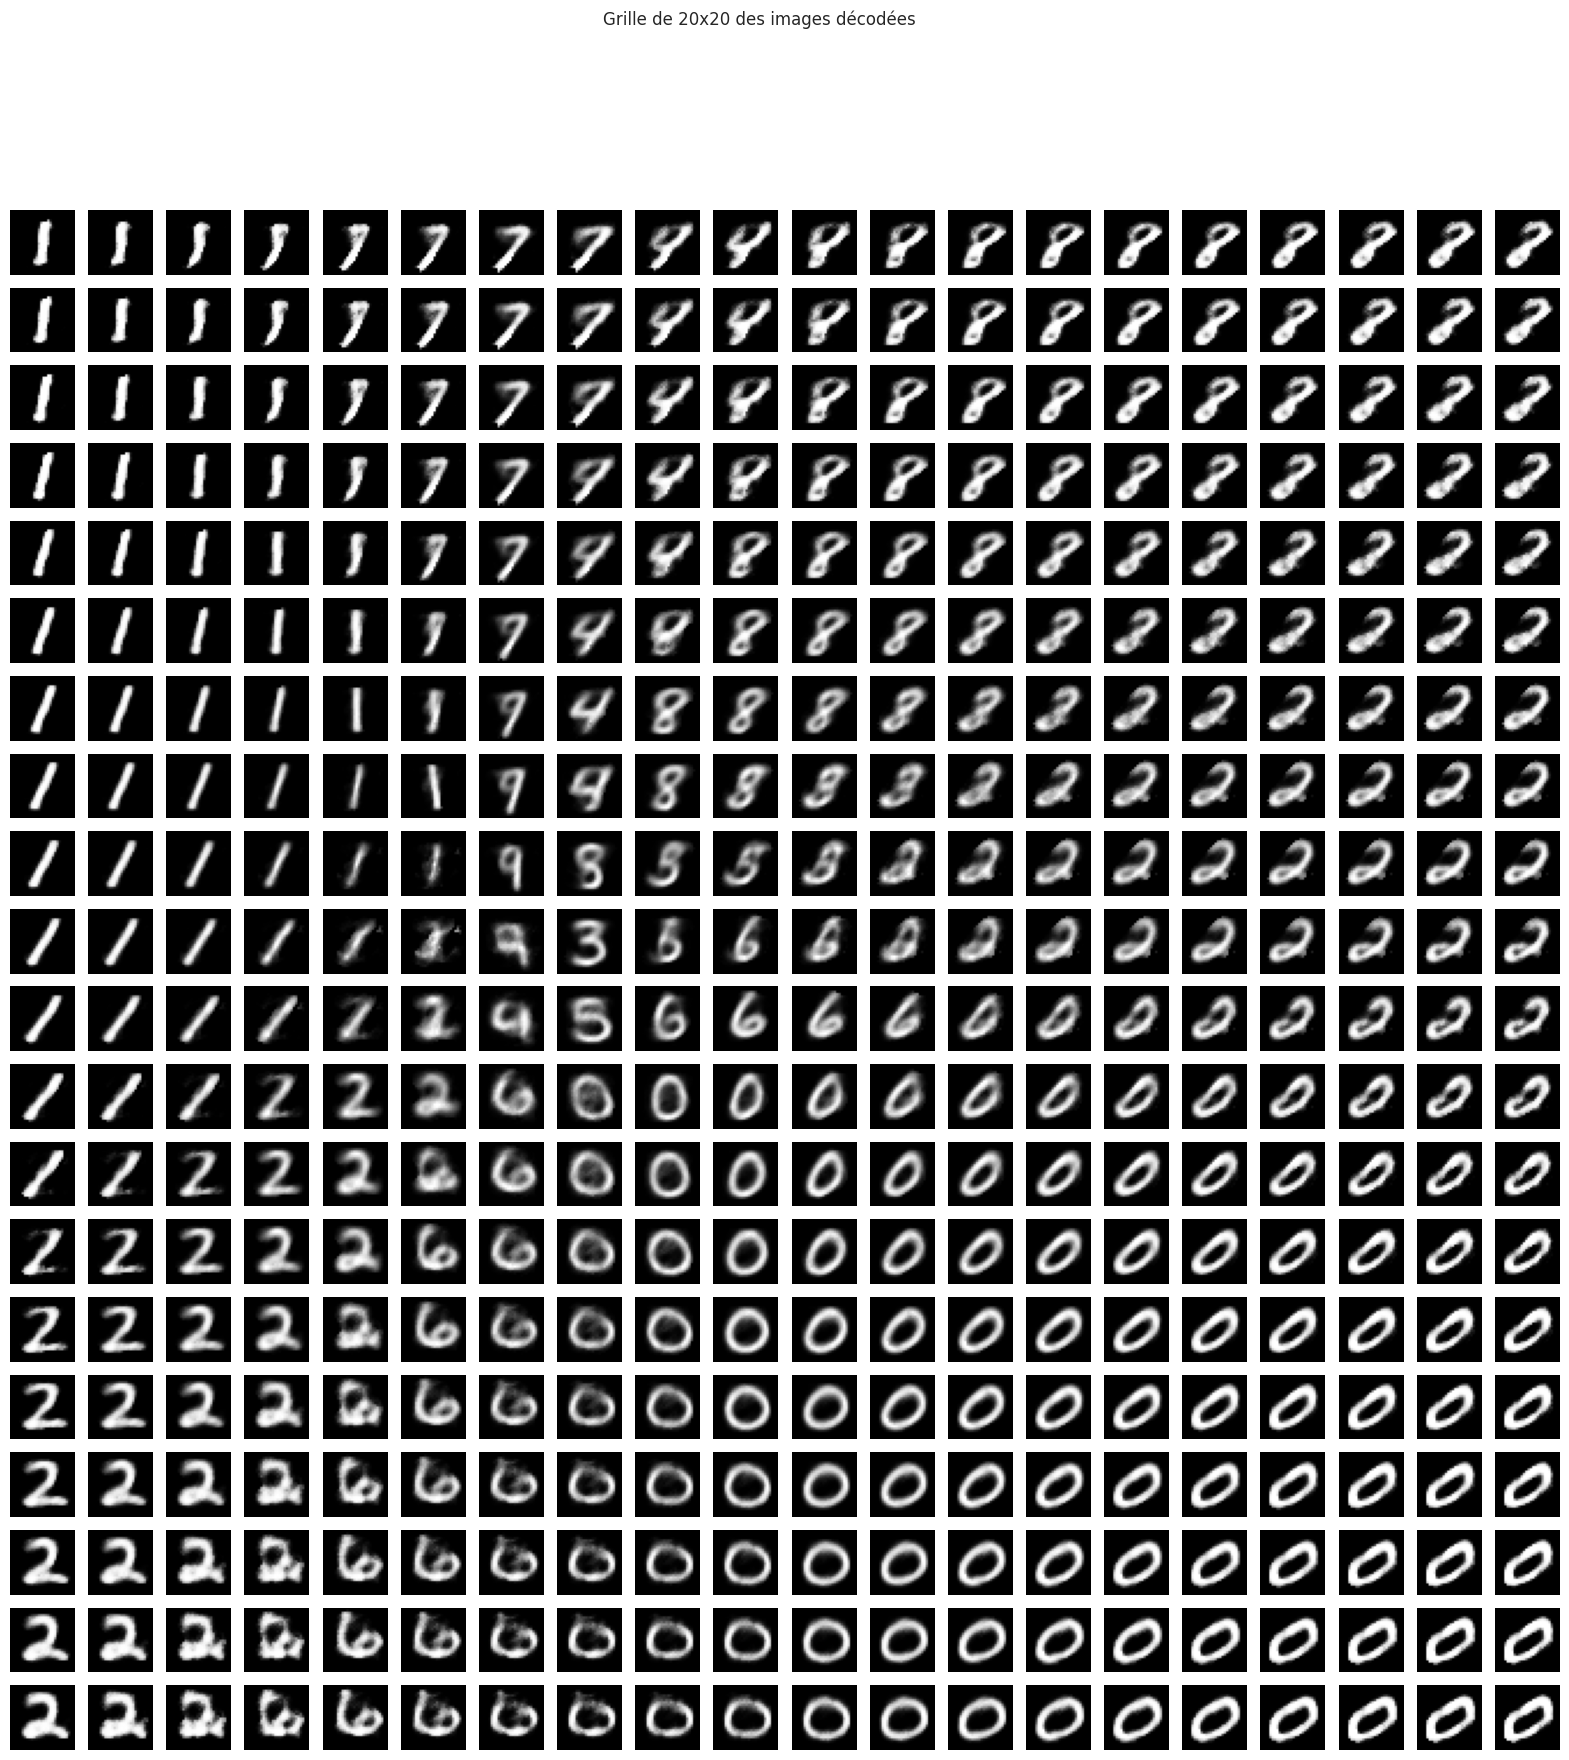

In [79]:
# Trouver le point le plus proche pour chaque cellule de la grille et afficher l'image
plt.figure(figsize=(20, 20))
for i in range(grid_size):
    for j in range(grid_size):
        # Trouver le point le plus proche de la cellule (i, j)
        x, y = x_coords[i], y_coords[j]
        tensor = torch.tensor([x, y], dtype=torch.float32).to(device)
        pt = model.forward_dec(tensor)

        pt = pt.detach().cpu().numpy()



        image = pt.reshape(28, 28)

        # Afficher l'image dans la grille
        plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

plt.suptitle('Grille de 20x20 des images décodées')
plt.show()